In [1]:
!pygmentize code/predictor.py

# This is the file that implements a flask server to do inferences. It's the file that you will modify to
# implement the scoring for your own algorithm.

from __future__ import print_function

import os
import json
import pickle
import sys
import signal
import traceback
import pickle
import torch
import torch_neuron
import transformers
from transformers import BertTokenizer
from transformers import BertModel
import math
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import logging
import numpy as np
import io
import urllib.request



try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3

import flask

import pandas as pd

prefix = '/opt/ml/'
model_path = os.path.join(prefix, 'model')

# A singleton for holding the model. This simply loads the model and holds it.
# It has a predict function that does a prediction based on the model and the input data.

class ScoringService(object):
    model =

In [3]:
!cat code/serve

#!/usr/bin/env python3

# This file implements the scoring service shell. You don't necessarily need to modify it for various
# algorithms. It starts nginx and gunicorn with the correct configurations and then simply waits until
# gunicorn exits.
#
# The flask server is specified to be the app object in wsgi.py
#
# We set the following parameters:
#
# Parameter                Environment Variable              Default Value
# ---------                --------------------              -------------
# number of workers        MODEL_SERVER_WORKERS              the number of CPU cores
# timeout                  MODEL_SERVER_TIMEOUT              60 seconds

from __future__ import print_function

import multiprocessing
import os
import signal
import subprocess
import sys

import logging
import threading
import time
import urllib.request
import boto3
import json
import os
from datetime import datetime
from time import sleep
import subprocess

from random import seed
from random import randint


In [4]:
!cat Dockerfile.sm.neuron-rtd

# Example neuron-rtd dockerfile.

# To build:
#    docker build . -f Dockerfile.neuron-rtd -t neuron-rtd

# Note: the container must start with CAP_SYS_ADMIN + CAP_IPC_LOCK capabilities in order
# to map the memory needed from the Infernetia devices. These capabilities will
# be dropped following initialization.

# i.e. To start the container with required capabilities:
#   docker run --env AWS_NEURON_VISIBLE_DEVICES="0" --cap-add SYS_ADMIN --cap-add IPC_LOCK -v /tmp/neuron_rtd_sock/:/sock neuron-rtd

FROM amazonlinux:2

MAINTAINER Chaitanya Hazarey <chazarey@amazon.com>

RUN echo $'[neuron] \n\
name=Neuron YUM Repository \n\
baseurl=https://yum.repos.neuron.amazonaws.com \n\
enabled=1' > /etc/yum.repos.d/neuron.repo

RUN rpm --import https://yum.repos.neuron.amazonaws.com/GPG-PUB-KEY-AMAZON-AWS-NEURON.PUB

RUN yum install -y wget 
RUN yum install -y aws-neuron-tools
RUN yum install -y aws-neuron-runtime
#RUN yum install -y python
RUN yum install -y tar gzip ca-certificates procps net-

In [5]:
!ls

code  Dockerfile.sm.neuron-rtd	inf1-container.ipynb  inference.py  README.md


In [6]:
%%sh 

# The name of our algorithm
algorithm_name=chazarey-inf1-serving-cm
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR

docker build -t ${algorithm_name} -f Dockerfile.sm.neuron-rtd .
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  99.33kB
Step 1/21 : FROM amazonlinux:2
 ---> ba2cc467a2bc
Step 2/21 : MAINTAINER Chaitanya Hazarey <chazarey@amazon.com>
 ---> Using cache
 ---> 088a31d5941a
Step 3/21 : RUN echo $'[neuron] \nname=Neuron YUM Repository \nbaseurl=https://yum.repos.neuron.amazonaws.com \nenabled=1' > /etc/yum.repos.d/neuron.repo
 ---> Using cache
 ---> 0769d0beed1b
Step 4/21 : RUN rpm --import https://yum.repos.neuron.amazonaws.com/GPG-PUB-KEY-AMAZON-AWS-NEURON.PUB
 ---> Using cache
 ---> 5eae2d75e8f3
Step 5/21 : RUN yum install -y wget
 ---> Using cache
 ---> dfd9fed5d8f0
Step 6/21 : RUN yum install -y aws-neuron-tools
 ---> Using cache
 ---> 276a5f678a9e
Step 7/21 : RUN yum install -y aws-neuron-runtime
 ---> Using cache
 ---> 1fd9585a3950
Step 8/21 : RUN yum install -y tar gzip ca-certificates procps net-tools which vim
 ---> Using cache
 ---> 43815f81991a
Step 9/21 : RUN amazon-linux-extras install -y nginx1
 ---> Using cache
 ---> d3b2f457d5e9


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [7]:
#!pip install 'sagemaker[local]' --upgrade

In [8]:
%%time

import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import csv_serializer

role = sagemaker.session.get_execution_role()

model_data='s3://inf1-compiled-model/model.tar.gz'

pytorch_model = PyTorchModel(model_data=model_data, 
                             role=role,
                             entry_point='inference.py',
                             image='111652037296.dkr.ecr.us-east-1.amazonaws.com/chazarey-inf1-serving-cm:latest',
                             framework_version='1.5.0',
                             enable_cloudwatch_metrics=True)

predictor = pytorch_model.deploy(instance_type='ml.inf1.xlarge', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Your model is not compiled. Please compile your model before using Inferentia.


-------------!CPU times: user 18.4 s, sys: 2.67 s, total: 21.1 s
Wall time: 6min 52s


In [9]:
!pip install transformers

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [10]:
import torch
import transformers
from transformers import BertTokenizer
from transformers import BertModel
import math
import numpy as np
import io
from sagemaker.predictor import csv_serializer, json_deserializer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle 

def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

# vnd indicates vendor-specific MIME types, which means they are MIME types that were 
# introduced by corporate bodies rather than e.g. an Internet consortium.


#-predictor.serializer = numpy_bytes_serializer
#-predictor.deserializer = csv_serializer

predictor.content_type = 'application/binary'
predictor.serializer = None
predictor.deserializer = None

sentence1="If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success."
sentence2="The greatest glory in living lies not in never falling, but in rising every time we fall."
sentence3="If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success. If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success. If you set your goals ridiculously high and it's a failure, you will fail above everyone else's success."

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

cos = torch.nn.CosineSimilarity()

encoded_sentence = tokenizer.encode_plus(sentence1, sentence3, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 

try:
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    raw_bytes = predictor.predict(pickled_bytes)
except:
    pass
    
    
#print(pickle.loads(raw_bytes))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
#type(encoded_sentence_tuple)#
#import pickle 
#msg = pickle.dumps(encoded_sentence_tuple)
#recd = pickle.loads(msg)
#type(recd)
#recd

In [12]:
import random

s_nouns = ["A dude", "My mom", "The king", "Some guy", "A cat with rabies", "A sloth", "Your homie", "This cool guy my gardener met yesterday", "Superman"]
p_nouns = ["These dudes", "Both of my moms", "All the kings of the world", "Some guys", "All of a cattery's cats", "The multitude of sloths living under your bed", "Your homies", "Like, these, like, all these people", "Supermen"]
s_verbs = ["eats", "kicks", "gives", "treats", "meets with", "creates", "hacks", "configures", "spies on", "retards", "meows on", "flees from", "tries to automate", "explodes"]
p_verbs = ["eat", "kick", "give", "treat", "meet with", "create", "hack", "configure", "spy on", "retard", "meow on", "flee from", "try to automate", "explode"]
infinitives = ["to make a pie.", "for no apparent reason.", "because the sky is green.", "for a disease.", "to be able to make toast explode.", "to know more about archeology."]

for i in range(0,10):    
    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    
    try:
        raw_bytes = predictor.predict(pickled_bytes)
        embeddings_returned = pickle.loads(raw_bytes)
        s1 = embeddings_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass

    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)
    
    try:
        raw_bytes = predictor.predict(pickled_bytes)
        embeddings_returned = pickle.loads(raw_bytes)
        s2 = embeddings_returned[1]
        #print(pickle.loads(raw_bytes))
    except:
        pass    
    
    cos = torch.nn.CosineSimilarity()    
    s2 = embeddings_returned[1]
    cos_sim = cos(s1,s2)
    cosine_measure = cos_sim[0].item()
    angle_in_radians = math.acos(cosine_measure)
    print(math.degrees(angle_in_radians))

13.970366695632904
16.322904834111583
30.797703771720812
10.04106705374436
91.31834721263706
27.373670006557752
96.60643695227958
87.13354474243069
108.36988154583487
23.193931968233258


In [16]:
import numpy as np 
import datetime
import math
import time
import boto3   
import matplotlib.pyplot as plt


endpoint_name=predictor.endpoint
total_runs=10000

In [17]:
print('Running {} inferences for {}:'.format(total_runs, endpoint_name))

client_times = []
errors_list = []
cw_start = datetime.datetime.utcnow()

errors = 0

for i in range(total_runs):    
    
    client_start = time.time()
    
    sentence_random = (random.choice(s_nouns) + ' ' + random.choice(s_verbs) + ' ' + random.choice(s_nouns).lower() or random.choice(p_nouns).lower() + ' ' + random.choice(infinitives))
    encoded_sentence = tokenizer.encode_plus(sentence1, sentence_random, max_length=128, pad_to_max_length=True, return_tensors="pt", truncation=True)
    encoded_sentence_tuple = encoded_sentence['input_ids'], encoded_sentence['attention_mask'], encoded_sentence['token_type_ids'] 
    
    pickled_bytes = pickle.dumps(encoded_sentence_tuple)

    try:
        raw_bytes = predictor.predict(pickled_bytes)
        errors_list.append(20)
    except:
        errors += 1
        errors_list.append(30)
        pass
    
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)
    
print('\nErrors - {:.4f} out of {:.4f} total runs | {:.4f}% \n'.format(errors, total_runs, (errors/total_runs)*100))
errors = 0
    
    
cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

print('Getting Cloudwatch:')
cloudwatch = boto3.client('cloudwatch')
statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
extended=['p50', 'p90', 'p95', 'p100']

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

# Period must be 1, 5, 10, 30, or multiple of 60
# Calculate closest multiple of 60 to the total elapsed time
factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
period = factor * 60
print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
print('Using period of {} seconds\n'.format(period))

cloudwatch_ready = False
# Keep polling CloudWatch metrics until datapoints are available
while not cloudwatch_ready:
  time.sleep(30)
  print('Waiting 30 seconds ...')
  # Must use default units of microseconds
  model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
  # Should be 1000
  if len(model_latency_metrics['Datapoints']) > 0:
    print('{} latency datapoints ready'.format(model_latency_metrics['Datapoints'][0]['SampleCount']))
    side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
    side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
    side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
    side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
    side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs
    print('Avg | P50 | P90 | P95 | P100')
    print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p100))

    cloudwatch_ready = True
    
    #embeddings_returned = pickle.loads(raw_bytes)
    #s1 = embeddings_returned[1]
    #print(pickle.loads(raw_bytes))

Running 10000 inferences for chazarey-inf1-serving-cm-2020-09-08-20-04-39-510:

Errors - 0.0000 out of 10000.0000 total runs | 0.0000% 

Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
33.9445 | 33.1944 | 36.1926 | 37.6600

Getting Cloudwatch:
Time elapsed: 639.479647 seconds
Using period of 660 seconds

Waiting 30 seconds ...
10000.0 latency datapoints ready
Avg | P50 | P90 | P95 | P100
2.3699 | 2.3470 | 2.5481 | 2.6646



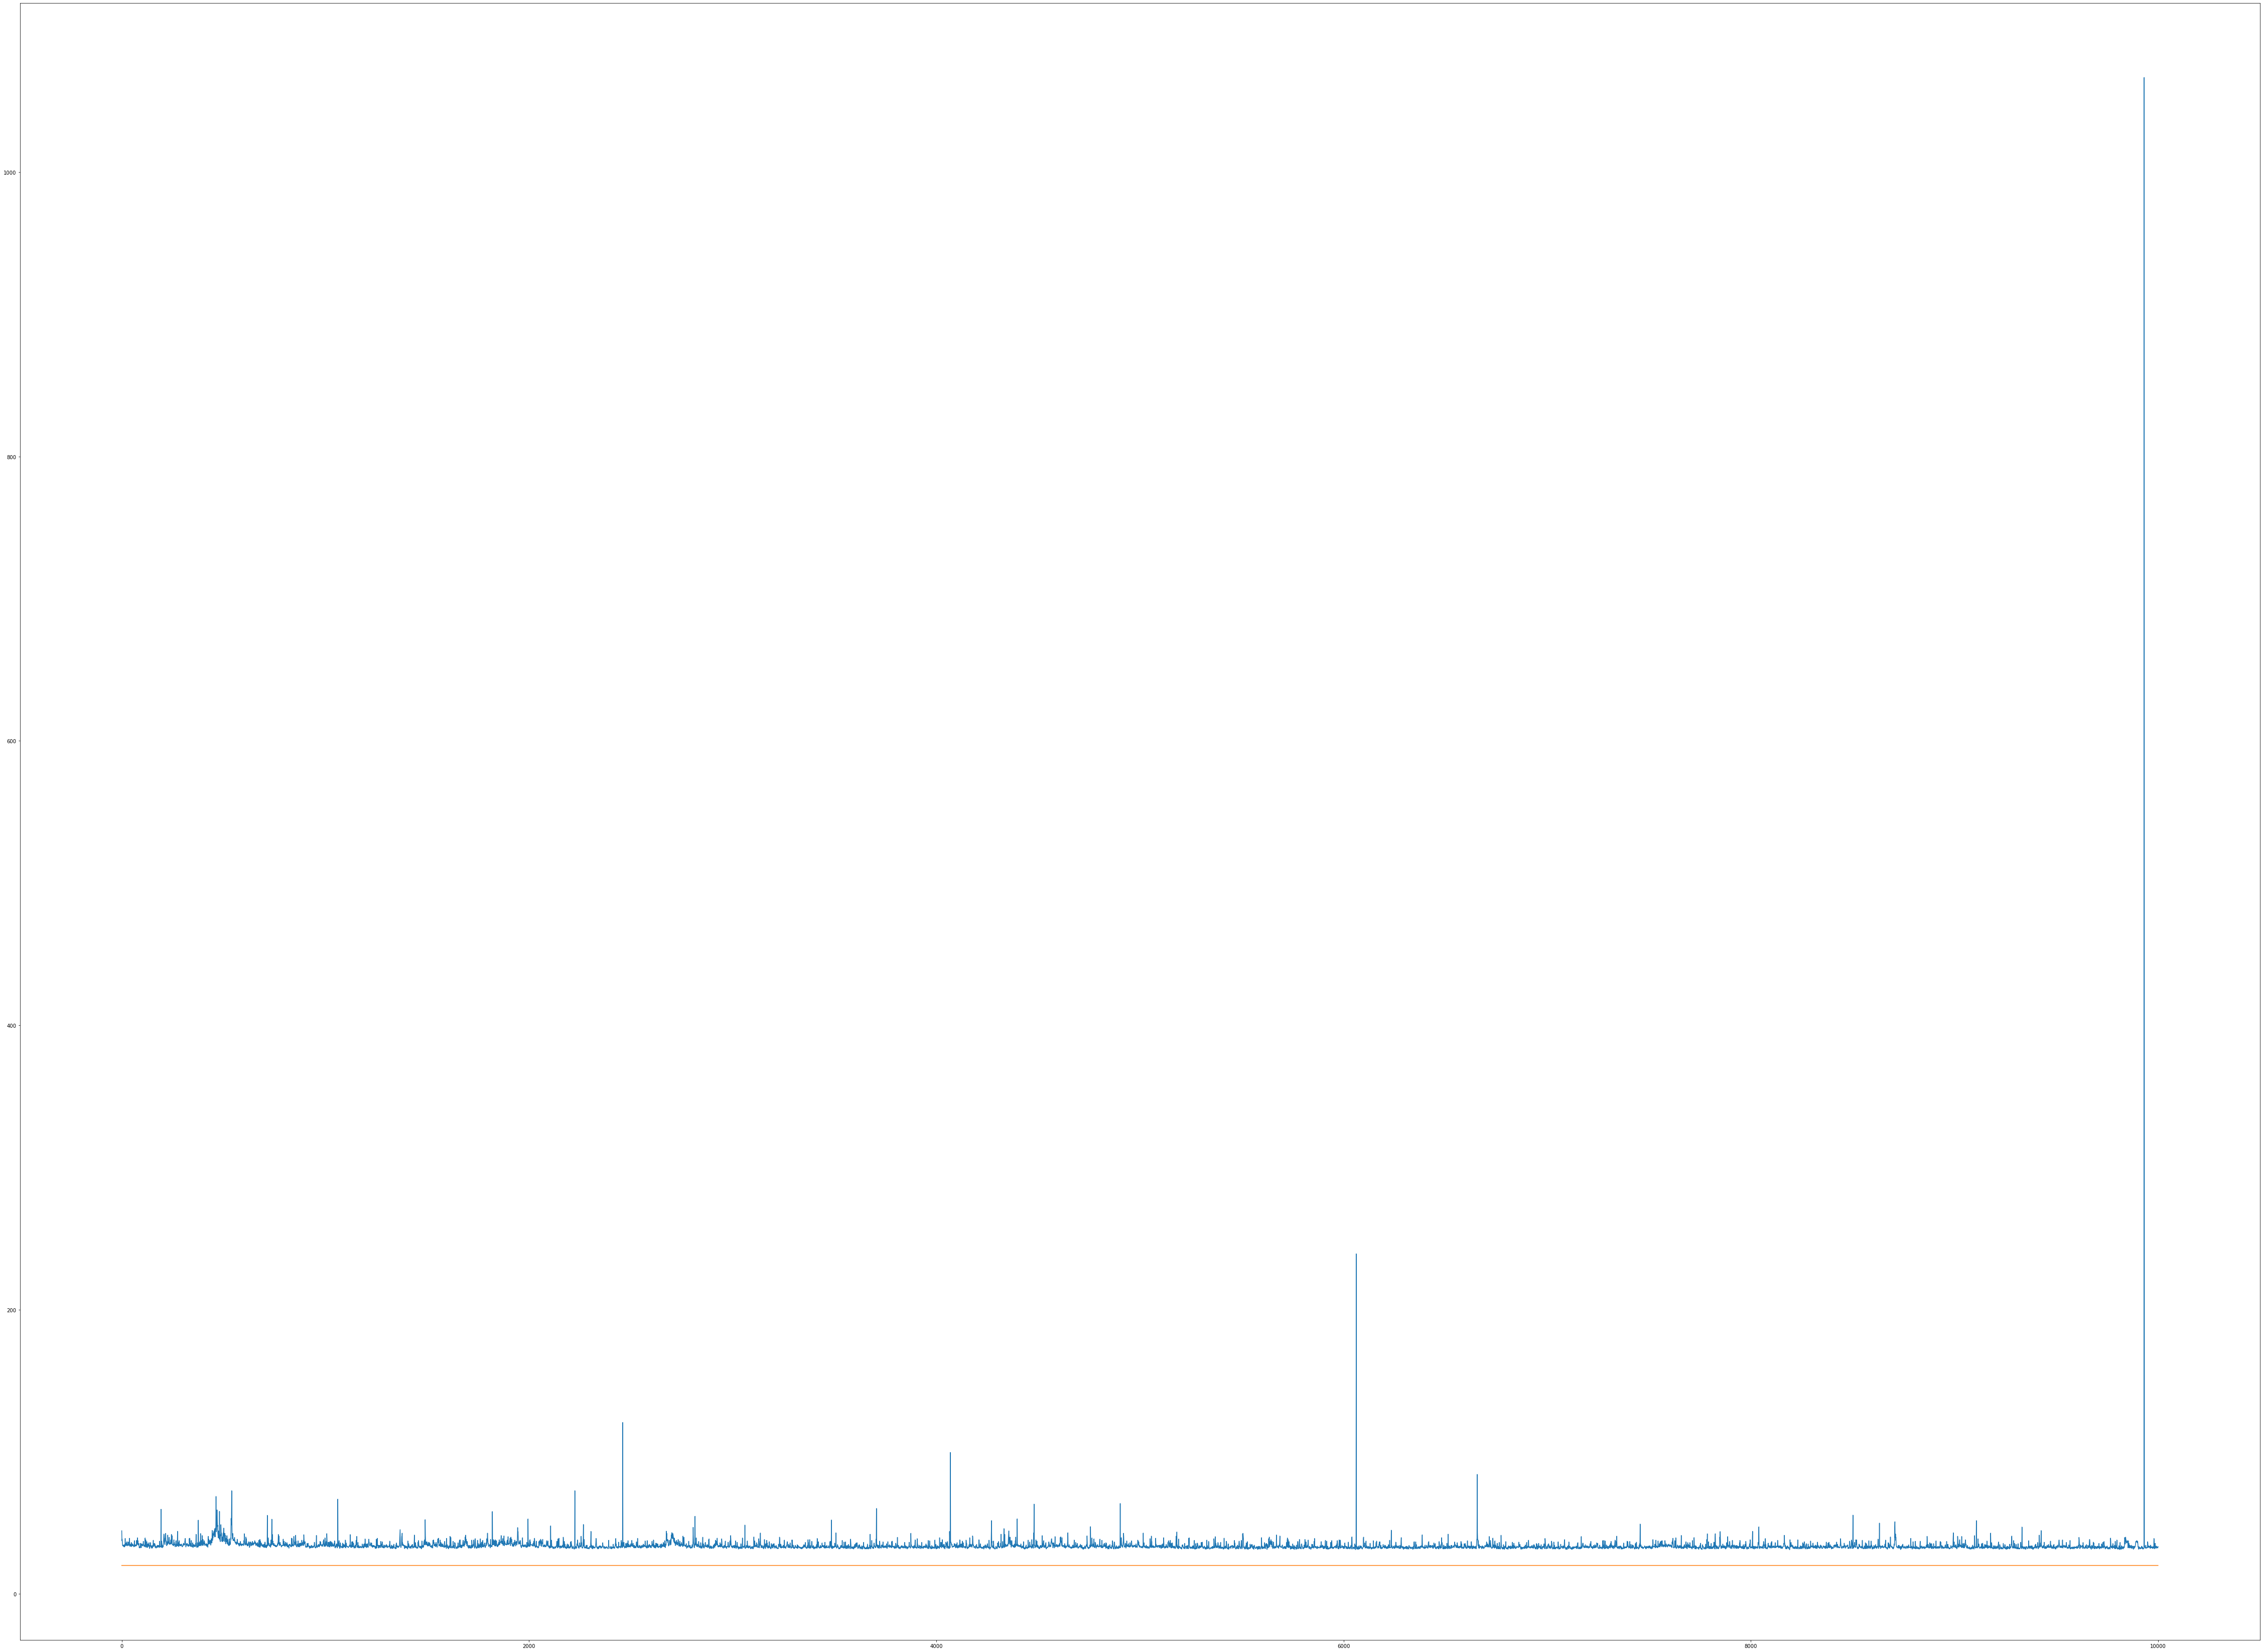

In [18]:
fig = plt.figure(figsize=(80, 60))
ax = fig.add_subplot(111)
ax.plot(client_times)
ax.plot(errors_list)

In [ ]:
#client_times

In [ ]:
c = '''client_times = []
cw_start = datetime.datetime.utcnow()

client_start = time.time()

time.sleep(1)

client_end = time.time()

client_times.append((client_end - client_start))

cw_end = datetime.datetime.utcnow()    
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))
'''